# Backtest the Kelly strategy for robustness

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from util_kelly import simulate_kelly_strategy, backtest_kelly_strategy, generate_simulation_plots

Here we want to backtest the Kelly Strategy from Notebook "03_analysis_kelly_strategy.ipynb" with parameters found to be near optimal. We will backtest against the historical S&P 500 data.

In [3]:
def optimized_kelly_strategy(data):
    return simulate_kelly_strategy(data, rebalancing_interval=1, annual_risk_free_rate=0.02,\
     window=350, min_kelly=0, max_kelly=10, kelly_fraction=0.4)

Test the strategy ove a horizon of 1, 2, 10, 20, 30 and 40 business years respectivly. We run the strategy on 1000 randomly picked starting dates.

In [4]:
investment_horizon = [252,504,2520,5040,7560,10080]
summary_statistics = pd.DataFrame()
histories = [None for _ in range(len(investment_horizon))]
for i, horizon in enumerate(investment_horizon):
    history, statistics = backtest_kelly_strategy(optimized_kelly_strategy, number_repeats=1000, investment_horizon=horizon)
    summary_statistics[f"date_{i}"] = statistics['date']
    summary_statistics[f"strategy_cum_returns_{i}"] = statistics['strategy_cum_returns']
    summary_statistics[f"cum_returns_{i}"] = statistics['cum_returns']
    histories[i] = history

For the mathematically inclined people among you, the summary statistics are printed below.

In [5]:
summary_statistics.describe()

,strategy_cum_returns_0,cum_returns_0,strategy_cum_returns_1,cum_returns_1,strategy_cum_returns_2,cum_returns_2,strategy_cum_returns_3,cum_returns_3,strategy_cum_returns_4,cum_returns_4,strategy_cum_returns_5,cum_returns_5
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.014802,0.032361,0.034029,0.071243,0.407200,0.329360,0.954783,0.667253,1.472705,0.996962,2.173798,1.343925
std,0.001302,0.161923,0.086775,0.216557,0.670896,0.410633,0.992819,0.567903,1.145927,0.683791,1.301680,0.780351
min,0.007622,-0.884239,-0.393146,-1.332137,-0.859911,-0.841892,-1.208614,-1.002910,-0.850206,-0.604823,-0.634991,-0.667829
25%,0.013595,-0.059068,0.027170,-0.044950,-0.089683,0.015077,0.098360,0.226048,0.488644,0.458755,1.221514,0.646929
50%,0.013909,0.051754,0.027346,0.093249,0.222487,0.324720,0.827413,0.613627,1.551284,0.941680,2.535668,1.507477
75%,0.016109,0.140804,0.032219,0.217041,0.864695,0.651680,1.838582,1.139132,2.518518,1.507545,3.047576,2.018746
max,0.016581,0.605294,0.550609,0.790476,2.663688,1.275383,3.125467,2.029106,3.654265,2.701678,4.458851,2.799810


We can see that the Kelly strategy is expected to statistically outperform buy and hold after 20 years, since that is the first time the median cumulative return of the Kelly strategy beats Buy and Hold. We can also see that the risk of running the Kelly strategy is always significantly higher than Buy and Hold (much greater standard deviation).

Now for the visually inclined people the boxplot graphic below. The box shows the range of the 1st to 3rd quartile, the bracket shows the standard deviation the green dotted line shows the median and the orange line shows the mean. The circles outside the boxes represent outliers.

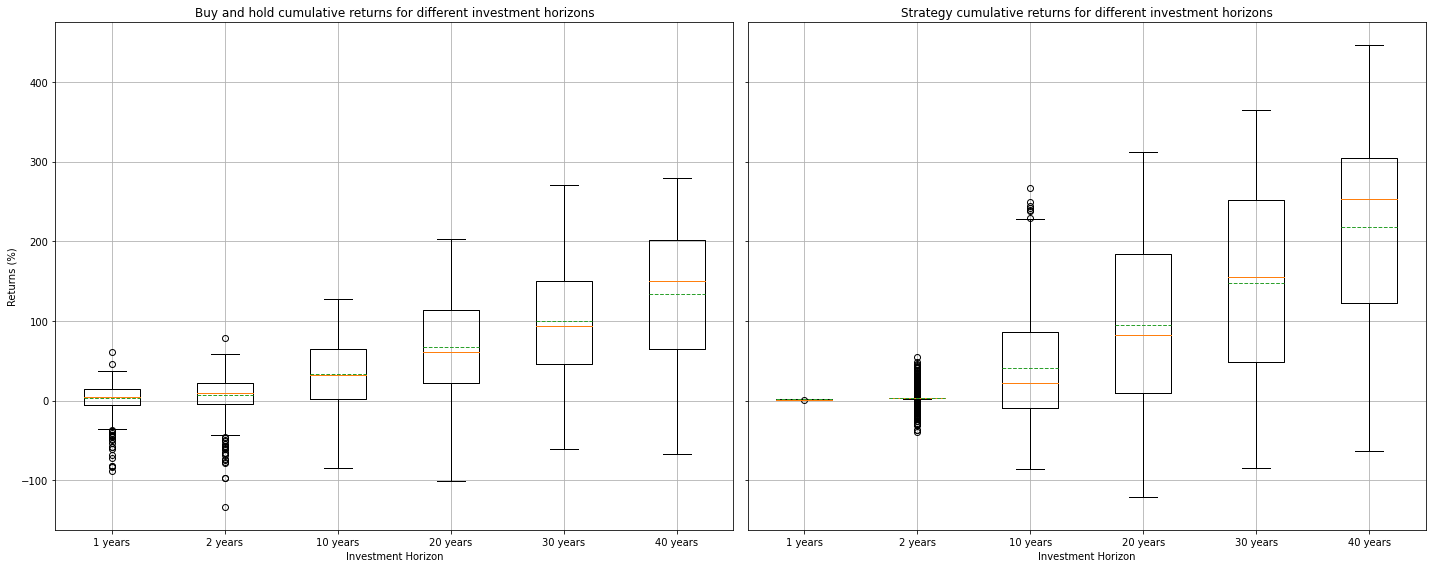

<Figure size 432x288 with 0 Axes>

In [6]:
fig, ax = plt.subplots(1,2, figsize=(20, 8), sharey=True)
baseline = pd.DataFrame()
strategy = pd.DataFrame()
for i, horizon in enumerate(investment_horizon):
    baseline[f"{horizon//252} years"] = summary_statistics[f"cum_returns_{i}"] * 100.0
    strategy[f"{horizon//252} years"] = summary_statistics[f"strategy_cum_returns_{i}"] * 100.0

ax[0].boxplot(baseline, showfliers=True, showmeans=True, meanline=True, widths=0.5, labels=baseline.columns)
ax[1].boxplot(strategy, showfliers=True, showmeans=True, meanline=True, widths=0.5, labels=strategy.columns)

ax[0].set_ylabel('Returns (%)')
ax[0].set_xlabel('Investment Horizon')
ax[0].set_title("Buy and hold cumulative returns for different investment horizons")
ax[0].grid(True)
ax[1].set_xlabel('Investment Horizon')
ax[1].set_title("Strategy cumulative returns for different investment horizons")
ax[1].grid(True)
plt.tight_layout()
plt.show()
plt.savefig('plots/boxplot_cumulative_returns.png')

And now for good measure, I show you some of the simulation runs for the 20 year investment horizon.

In [8]:
history = histories[3] # 20 year simulation
max_samples = 100
generate_simulation_plots(history, max_samples=max_samples, filename="horizon_20y")

In [9]:
!convert -delay 66 -loop 10 plots/tmp/horizon_20y*.png plots/horizon_20y.gif

![SegmentLocal](plots/horizon_20y.gif)